# Adagrad based matrix factorization
> Adagrad optimizer for matrix factorisation

- toc: true 
- badges: true
- comments: true
- author: Nipun Batra
- categories: [ML]

In a [previous post](./nnmf-tensorflow.html), we had seen how to perfom non-negative matrix factorization (NNMF) using Tensorflow. In [another previous post](./linear-regression-adagrad-vs-gd.html), I had shown how to use Adagrad for linear regression. This current post can be considered an extension of the linear regression using Adagrad post. Just for the purpose of education, I'll poorly initialise the estimate of one of the decomposed matrix, to see how well Adagrad can adjust weights!

### Customary imports

In [1]:
import autograd.numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
from matplotlib import gridspec

%matplotlib inline

### Creating the matrix to be decomposed

In [2]:
A = np.array([[3, 4, 5, 2],
                   [4, 4, 3, 3],
                   [5, 5, 4, 3]], dtype=np.float32).T

### Masking one entry

In [3]:
A[0, 0] = np.NAN

In [4]:
A

array([[ nan,   4.,   5.],
       [  4.,   4.,   5.],
       [  5.,   3.,   4.],
       [  2.,   3.,   3.]], dtype=float32)

### Defining the cost function

In [5]:
def cost(param_list):
    W, H = param_list
    pred = np.dot(W, H)
    mask = ~np.isnan(A)
    return np.sqrt(((pred - A)[mask].flatten() ** 2).mean(axis=None))

### Decomposition params

In [6]:
rank = 2
learning_rate=0.01
n_steps = 10000

### Adagrad routine

In [7]:
def adagrad_gd(param_init, cost, niter=5, lr=1e-2, eps=1e-8, random_seed=0):
    """
    param_init: List of initial values of parameters
    cost: cost function
    niter: Number of iterations to run
    lr: Learning rate
    eps: Fudge factor, to avoid division by zero
    """
    from copy import deepcopy
    from autograd import grad
    # Fixing the random_seed
    np.random.seed(random_seed)
    
    # Function to compute the gradient of the cost function
    grad_cost = grad(cost)
    params = deepcopy(param_init)
    param_array, grad_array, lr_array, cost_array = [params], [], [[lr*np.ones_like(_) for _ in params]], [cost(params)]
    # Initialising sum of squares of gradients for each param as 0
    sum_squares_gradients = [np.zeros_like(param) for param in params]
    for i in range(niter):
        out_params = []
        gradients = grad_cost(params)
        # At each iteration, we add the square of the gradients to `sum_squares_gradients`
        sum_squares_gradients= [eps + sum_prev + np.square(g) for sum_prev, g in zip(sum_squares_gradients, gradients)]
        # Adapted learning rate for parameter list
        lrs = [np.divide(lr, np.sqrt(sg)) for sg in sum_squares_gradients]
        # Paramter update
        params = [param-(adapted_lr*grad_param) for param, adapted_lr, grad_param in zip(params, lrs, gradients)]
        param_array.append(params)
        lr_array.append(lrs)
        grad_array.append(gradients)
        cost_array.append(cost(params))
        
    return params, param_array, grad_array, lr_array, cost_array

### Running Adagrad

#### Fixing initial parameters

I'm poorly initialising `H` here to see how the learning rates vary for `W` and `H`.

In [8]:
np.random.seed(0)
shape = A.shape
H_init =  -5*np.abs(np.random.randn(rank, shape[1]))
W_init =  np.abs(np.random.randn(shape[0], rank))
param_init = [W_init, H_init]

In [9]:
H_init

array([[ -8.82026173,  -2.00078604,  -4.89368992],
       [-11.204466  ,  -9.33778995,  -4.8863894 ]])

In [10]:
W_init

array([[ 0.95008842,  0.15135721],
       [ 0.10321885,  0.4105985 ],
       [ 0.14404357,  1.45427351],
       [ 0.76103773,  0.12167502]])

In [11]:
# Cost for initial set of parameters
cost(param_init)

11.651268820608442

In [12]:
lr = 0.1
eps=1e-8
niter=2000
ada_params, ada_param_array, ada_grad_array, ada_lr_array, ada_cost_array = adagrad_gd(param_init, cost, niter=niter, lr=lr, eps=eps)

#### Cost v/s # iterations

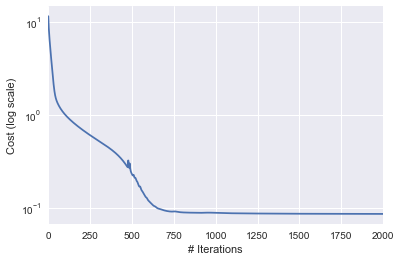

In [13]:
pd.Series(ada_cost_array).plot(logy=True)
plt.ylabel("Cost (log scale)")
plt.xlabel("# Iterations")

#### Final set of parameters and recovered matrix

In [14]:
W_final, H_final = ada_params
pred = np.dot(W_final, H_final)
pred_df = pd.DataFrame(pred).round()
pred_df

,0,1,2
0,5.0,4.0,5.0
1,4.0,4.0,5.0
2,5.0,3.0,4.0
3,2.0,3.0,3.0


#### Learning rate evolution for W

In [15]:
W_lrs = np.array(ada_lr_array)[:, 0]

In [16]:
W_lrs = np.array(ada_lr_array)[:, 0]
fig= plt.figure(figsize=(4, 2))
gs = gridspec.GridSpec(1, 2, width_ratios=[8, 1]) 
ax = plt.subplot(gs[0]),  plt.subplot(gs[1])
max_W, min_W = np.max([np.max(x) for x in W_lrs]), np.min([np.min(x) for x in W_lrs])

def update(iteration):
    ax[0].cla()
    ax[1].cla()
    sns.heatmap(W_lrs[iteration], vmin=min_W, vmax=max_W, ax=ax[0], annot=True, fmt='.4f', cbar_ax=ax[1])
    ax[0].set_title("Learning rate update for W\nIteration: {}".format(iteration))
    fig.tight_layout()

anim = FuncAnimation(fig, update, frames=np.arange(0, 200, 10), interval=500)
anim.save('W_update.gif', dpi=80, writer='imagemagick')
plt.close()


![](https://nipunbatra.github.io/blog/images/W_update.gif)

#### Learning rate evolution for H

In [18]:
H_lrs = np.array(ada_lr_array)[:, 1]

fig= plt.figure(figsize=(4, 2))
gs = gridspec.GridSpec(1, 2, width_ratios=[10, 1]) 
ax = plt.subplot(gs[0]),  plt.subplot(gs[1])
max_H, min_H = np.max([np.max(x) for x in H_lrs]), np.min([np.min(x) for x in H_lrs])

def update(iteration):
    ax[0].cla()
    ax[1].cla()
    sns.heatmap(H_lrs[iteration], vmin=min_H, vmax=max_H, ax=ax[0], annot=True, fmt='.2f', cbar_ax=ax[1])
    ax[0].set_title("Learning rate update for H\nIteration: {}".format(iteration))
    fig.tight_layout()

anim = FuncAnimation(fig, update, frames=np.arange(0, 200, 10), interval=500)
anim.save('H_update.gif', dpi=80, writer='imagemagick')
plt.close()


![](https://nipunbatra.github.io/blog/images/H_update.gif)